<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Dataset" data-toc-modified-id="Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataset</a></span><ul class="toc-item"><li><span><a href="#load-training-genotype-and-testing-genotype-data" data-toc-modified-id="load-training-genotype-and-testing-genotype-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>load training genotype and testing genotype data</a></span></li><li><span><a href="#Load-pedigree" data-toc-modified-id="Load-pedigree-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Load pedigree</a></span></li><li><span><a href="#HLA-genotype-of-ESA-population" data-toc-modified-id="HLA-genotype-of-ESA-population-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>HLA genotype of ESA population</a></span></li><li><span><a href="#Sample-visualization" data-toc-modified-id="Sample-visualization-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Sample visualization</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Preprocessing</a></span></li></ul></li><li><span><a href="#Method" data-toc-modified-id="Method-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Method</a></span><ul class="toc-item"><li><span><a href="#Build-model" data-toc-modified-id="Build-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Build model</a></span></li><li><span><a href="#Generate-data" data-toc-modified-id="Generate-data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Generate data</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Training</a></span></li></ul></li><li><span><a href="#Prediction" data-toc-modified-id="Prediction-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Prediction</a></span></li></ul></div>

# Introduction

This is a simple CNN denoising autoencoder for genotype impuation. The performance is assayed on HLA genotype.

<img src='SCDA4HLA_OneHot.png' alt='overview' style="width:50%"/>


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pylab as pl
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import h5py

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, UpSampling1D, UpSampling2D, AveragePooling1D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.regularizers import l1, l1, l1_l2
from tensorflow.keras.utils import to_categorical

# specify a seed for repeating the exactly results
np.random.seed(seed=28213)

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (typ

# Dataset 

HLA genotype from Eastern Asian (ESA) super population in 1000Genome 

1000Genome pedigree table 

<img src='1000Genome_pedigree.png' alt='overview' style="width:80%"/>

## load training genotype and testing genotype data

train dataset: (27209, 2003)  
test dataset: (27209, 501)

They should be transposed before training

In [2]:
HLA_geno_file = '../HLA_geno.csv'
HLA_geno = pd.read_csv(HLA_geno_file, sep='\t').transpose()
HLA_geno.shape

(2504, 27209)

In [3]:
HLA_geno.head()

,0,1,2,3,4,5,6,7,8,9,...,27199,27200,27201,27202,27203,27204,27205,27206,27207,27208
HG00096,1,1,1,1,1,1,1,1,1,1,...,1,2,2,2,1,1,1,1,1,2
HG00097,1,1,3,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
HG00099,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,2,1,1,2,1,1
HG00100,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
HG00101,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,3,1,1,3,1,1


## Load pedigree

In [4]:
#load pedigree
ped_file = '../20130606_g1k-1.ped' 
pedigree = pd.read_csv(ped_file, sep='\t')
pedigree.head()

,Family ID,Individual ID,Paternal ID,Maternal ID,Gender,Phenotype,Population,Relationship,Siblings,Second Order,Third Order,Other Comments
0,BB01,HG01879,0,0,1,0,ACB,father,0,0,0,0
1,BB01,HG01880,0,0,2,0,ACB,mother,0,0,0,0
2,BB01,HG01881,HG01879,HG01880,2,0,ACB,child,0,0,0,0
3,BB02,HG01882,0,0,1,0,ACB,father,0,0,0,0
4,BB02,HG01883,0,0,2,0,ACB,mother,0,0,0,0


In [5]:
# select population in EAS (east asians)
individual_id = pedigree[(pedigree['Population'] == 'CHB') |
                         (pedigree['Population'] == 'CDX') |
                         (pedigree['Population'] == 'CHD') |
                         (pedigree['Population'] == 'CHS') |
                         (pedigree['Population'] == 'JPT') |
                         (pedigree['Population'] == 'KHV')]['Individual ID']

len(individual_id)

617

## HLA genotype of ESA population

In [6]:
# intersection
HLA_geno.index.isin(individual_id)

array([False, False, False, ..., False, False, False])

In [7]:
EAS_geno=HLA_geno.iloc[HLA_geno.index.isin(individual_id)]
EAS_geno.head()

,0,1,2,3,4,5,6,7,8,9,...,27199,27200,27201,27202,27203,27204,27205,27206,27207,27208
HG00403,1,1,1,1,1,1,1,1,1,1,...,1,2,1,2,1,1,1,1,1,2
HG00404,1,1,1,1,1,1,1,1,1,1,...,1,2,1,2,1,1,1,1,1,2
HG00406,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,3,1,1,3,1,1
HG00407,1,1,1,1,1,1,1,1,1,1,...,1,3,1,3,1,1,1,1,1,3
HG00409,1,1,1,1,1,1,1,1,1,1,...,1,2,1,2,1,1,1,1,1,2


## Sample visualization

In [8]:
# the first sample in dataset
vis_sample=EAS_geno.iloc[0].values[:27200].reshape(160,170)

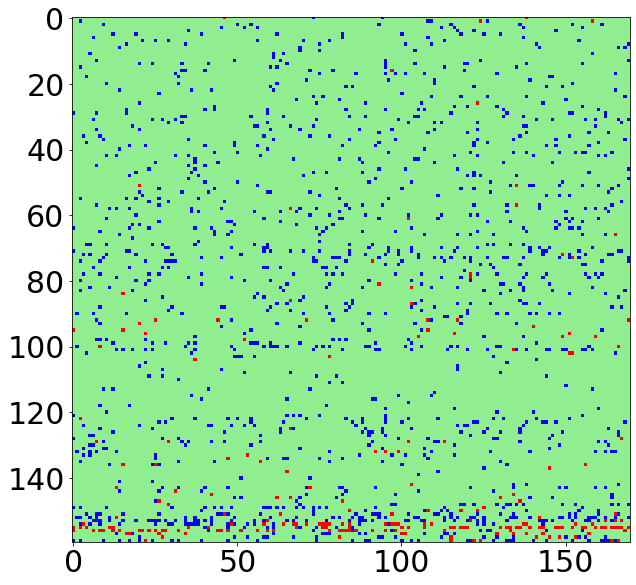

In [9]:
# draw first train sample, which was reshaped to (50,100)
plt.figure(figsize=(10, 10))
ax = plt.gca()
cmap = mpl.colors.ListedColormap(['lightgreen', 'blue', 'red'])
im = ax.imshow(vis_sample, cmap=cmap)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
plt.tick_params(labelsize=30)
plt.rcParams["font.family"] = ['Times New Roman'] + plt.rcParams['font.serif']
# plt.colorbar(im, cax=cax)
plt.show()

## Preprocessing

In [10]:
EAS_geno=EAS_geno-1 # encoding 0, 1, 2
EAS_geno.head()

,0,1,2,3,4,5,6,7,8,9,...,27199,27200,27201,27202,27203,27204,27205,27206,27207,27208
HG00403,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
HG00404,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
HG00406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,2,0,0
HG00407,0,0,0,0,0,0,0,0,0,0,...,0,2,0,2,0,0,0,0,0,2
HG00409,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1


In [11]:
EAS_geno=EAS_geno.iloc[:,:27208] # for autoencoder

In [12]:
# one hot encode
EAS_onehot = to_categorical(EAS_geno)
EAS_onehot.shape

(504, 27208, 3)

In [13]:
# split df to train and test
train_X, test_X = train_test_split(EAS_onehot, test_size=0.2)

train_X.shape, test_X.shape

((403, 27208, 3), (101, 27208, 3))

In [14]:
# split df to train and valid
train_X, valid_X = train_test_split(train_X, test_size=0.2)

train_X.shape, valid_X.shape

((322, 27208, 3), (81, 27208, 3))

# Method

## Build model

In [73]:
# hyperparameters
missing_perc = 0.1

# training
batch_size = 32
learning_rate =1e-3
epochs = 50

# conv1D
feature_size = train_X.shape[1]
inChannel = train_X.shape[2]
kr = 1e-6
drop_prec = 0.25

In [16]:
SCDA = Sequential()

# encoder
SCDA.add(
    Conv1D(
        32,
        5,
        padding='same',
        activation='relu',
        kernel_regularizer=l1(kr),
        input_shape=(feature_size, inChannel)))
SCDA.add(MaxPooling1D(pool_size=2))
SCDA.add(Dropout(drop_prec))

SCDA.add(
    Conv1D(
        64, 5, padding='same', activation='relu', kernel_regularizer=l1(kr)))
SCDA.add(MaxPooling1D(pool_size=2))
SCDA.add(Dropout(drop_prec))

# small and thick
SCDA.add(
    Conv1D(
        128, 5, padding='same', activation='relu', kernel_regularizer=l1(kr)))

# decoder
SCDA.add(
    Conv1D(
        64, 5, padding='same', activation='relu', kernel_regularizer=l1(kr)))
SCDA.add(UpSampling1D(2))
SCDA.add(Dropout(drop_prec))

SCDA.add(
    Conv1D(
        32, 5, padding='same', activation='relu', kernel_regularizer=l1(kr)))
SCDA.add(UpSampling1D(2))
SCDA.add(Dropout(drop_prec))

SCDA.add(
    Conv1D(
        inChannel, 5, activation='softmax', padding='same',
        kernel_regularizer=l1(kr)))  # for categorical loss

# compile
SCDA.compile(
    loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

SCDA.summary()

W0729 12:58:20.289779 4502459840 deprecation.py:506] From /usr/local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 27208, 32)         512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 13604, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 13604, 32)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 13604, 64)         10304     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6802, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6802, 64)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6802, 128)         4

## Generate data

In [17]:
# Generates data for denoising autoencoder.
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, x_dataset, missing_perc=0.1, shuffle=True):
        self.batch_size = batch_size
        self.x = x_dataset
        self.missing_perc = missing_perc
        self.shuffle = shuffle
        # triggered once at the very beginning as well as at the end of each epoch.
        self.on_epoch_end()

    def __len__(self):
        # Denote the number of batches per epoch
        return int(np.floor(self.x.shape[0] / self.batch_size))

    def __getitem__(self, index):
        # Generates one batch of data
        indexes = self.indexes[index * self.batch_size:(
            index + 1) * self.batch_size]
        self.x_missing = self.x[indexes].copy()

        # Generates missing genotypes
        # different missing loci for each individuals
        for i in range(self.x_missing.shape[0]):
            missing_size = int(self.missing_perc * self.x_missing.shape[1])
            missing_index = np.random.randint(
                self.x_missing.shape[1], size=missing_size)
            self.x_missing[i, missing_index, :] = 0

        return self.x_missing, self.x[indexes]

    def on_epoch_end(self):
        # Update indexes after each epoch
        self.indexes = np.arange(self.x.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [18]:
train_generator = DataGenerator(
    batch_size=batch_size, x_dataset=train_X, missing_perc=missing_perc)
valid_generator = DataGenerator(
    batch_size=batch_size, x_dataset=valid_X, missing_perc=missing_perc)

In [19]:
# train_generator.__getitem__(0)[0]

## Training

In [20]:
# early stopping call back with val_loss monitor
EarlyStopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True)

# model checkpoint call back with val_acc monitor
ModelCheckpoint = keras.callbacks.ModelCheckpoint(
    'models/checkpoint.{epoch:02d}-{val_acc:.4f}.h5',
    monitor='val_acc',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)

W0729 12:58:26.948770 4502459840 callbacks.py:875] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


In [ ]:
SCDA_train = SCDA.fit_generator(
    generator=train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    verbose=1,    
    callbacks=[EarlyStopping, ModelCheckpoint]
)

# autoencoder_train = autoencoder.fit(
#     train_X,
#     train_Y,
#     batch_size=batch_size,
#     epochs=epochs,
#     verbose=1,
#     validation_data=(valid_X, valid_Y),
#     callbacks=[EarlyStopping,ModelCheckpoint])

Epoch 1/50
10/10 [==============================] - 27s 3s/step - loss: 0.0518 - acc: 0.9883 - val_loss: 0.0373 - val_acc: 0.9934
Epoch 2/50
10/10 [==============================] - 28s 3s/step - loss: 0.0514 - acc: 0.9884 - val_loss: 0.0376 - val_acc: 0.9933
Epoch 3/50
10/10 [==============================] - 28s 3s/step - loss: 0.0512 - acc: 0.9885 - val_loss: 0.0377 - val_acc: 0.9934
Epoch 4/50
10/10 [==============================] - 27s 3s/step - loss: 0.0510 - acc: 0.9886 - val_loss: 0.0371 - val_acc: 0.9935
Epoch 5/50
10/10 [==============================] - 27s 3s/step - loss: 0.0507 - acc: 0.9887 - val_loss: 0.0367 - val_acc: 0.9936
Epoch 6/50
10/10 [==============================] - 28s 3s/step - loss: 0.0506 - acc: 0.9887 - val_loss: 0.0368 - val_acc: 0.9936
Epoch 7/50
10/10 [==============================] - 27s 3s/step - loss: 0.0505 - acc: 0.9888 - val_loss: 0.0369 - val_acc: 0.9936
Epoch 8/50
10/10 [==============================] - 26s 3s/step - loss: 0.0501 - acc: 0.98

In [ ]:
# plot loss curve on validation data
loss = SCDA_train.history['loss']
val_loss = SCDA_train.history['val_loss']

plt.figure()
plt.plot(range(len(loss)), loss, 'bo', label='Training loss')
plt.plot(range(len(val_loss)), val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# plot accuracy curve on validation data
acc = SCDA_train.history['acc']
val_acc = SCDA_train.history['val_acc']
plt.figure()
plt.plot(range(len(acc)), acc, 'bo', label='Training acc')
plt.plot(range(len(val_acc)), val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.show()

# Prediction

In [ ]:
test_X_missing = test_X.copy()

In [ ]:
accuracy=[]
for i in range(test_X_missing.shape[0]):
    # Generates missing genotypes
    missing_size= int(missing_perc*test_X_missing.shape[1])
    missing_index = np.random.randint(test_X_missing.shape[1], size=missing_size)
    test_X_missing[i, missing_index, :] = 0
    
    # predict
    predict_onehot = SCDA.predict(test_X_missing[i:i+1,:,:])
    # only care the missing position
    predict_missing_onehot = predict_onehot[0:1, missing_index, :]
    predict_missing=np.argmax(predict_missing_onehot, axis=2)
    
    # label
    label_missing_onehot = test_X[i:i+1, missing_index, :]
    label_missing=np.argmax(label_missing_onehot, axis=2)

    # accuracy
    correct_prediction = np.equal(predict_missing, label_missing)
    accuracy.append(np.mean(correct_prediction))


In [ ]:
np.mean(accuracy)